**Disclamer** 
Some of the code (Data augmenter and generator) was found online, I don't remember the source, if you have it, please message me so that I can add the source

Please cite the following if you are to use the dataset:
<br>
Belkis Asma Semcheddine, Abdelhamid Daamouche, and Youyou Li, "U-Net Based Classification For Urban Areas In Algeria," In 2020 Mediterranean and Middle-East Geoscience and Remote Sensing Symposium (M2GARSS), Tunis, Tunisia, 2020, pp. 101-104, doi: 10.1109/M2GARSS47143.2020.9105283.

In [2]:
# !pip install --user albumentations==0.4.3

## Importing libraries

In [3]:
## Imports
import os 
import random

import numpy as np
import pandas as pd

import sklearn
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from PIL import Image

import albumentations as A # For augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

## Loading the data image and mask

Text(0.5, 1.0, 'Mask Image')

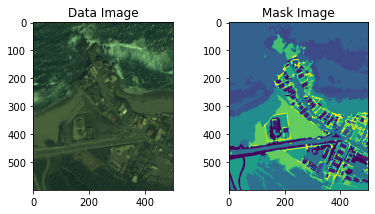

In [4]:
# Reading all data and retrieving labels
data_path = "Boumerdes_dataset"
ids = "Boumerdes"
sample_size = 64

image_path = os.path.join(data_path,"Data" , ids) + ".tif"
gt_path = os.path.join(data_path,"Mask" , ids) + ".png"

image = cv2.imread(image_path, 1)
gt = cv2.imread(gt_path, 0)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(image)
plt.title("Data Image")
ay = fig.add_subplot(1, 2, 2)
ay.imshow(gt)
plt.title("Mask Image")

### Gray level mask into labels

In [5]:
gt_labels = list(np.unique(gt))
print("Ground truth labels: ", gt_labels)

mask = np.zeros(gt.shape, dtype=np.uint8)
for x_idx in range(gt.shape[0]):
    for y_idx in range(gt.shape[1]):
        mask[x_idx, y_idx] = gt_labels.index(gt[x_idx, y_idx])
        
labels = np.unique(mask)
print("Mask labels: ", labels)

Ground truth labels:  [29, 45, 76, 80, 88, 100, 112, 116, 140, 155, 166, 188, 202, 255]
Mask labels:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


## Functions

### One-hot encoder

In [6]:
def encode_one_hot(mask):
    sample_size, sample_size = mask.shape
    one_hot_mask = np.zeros((sample_size, sample_size, len(labels)))
    i = 0
    for c in labels :
        one_hot_mask[:,:,i] = np.where(mask == c, 1, 0)
        i = i + 1
    return one_hot_mask

### Patch cropping

In [7]:
def crop_image(image, mask, strips):
    image_batches = []
    mask_batches = []
    for i in strips :
        left = horizontal_pixel_crop[i]
        right = left + sample_size
        for j in vertical_pixel_crop :
            upper = j
            lower = j + sample_size
            crop_rectangle = (left, upper, right, lower)
            __img = Image.fromarray(image)
            __mask = Image.fromarray(mask)
            __img = __img.crop(crop_rectangle)
            __mask = __mask.crop(crop_rectangle)
            __img = np.array(__img) 
            __mask = np.array(__mask) 
            image_batches.append(__img)
            mask_batches.append(__mask)
            
#     image_batches = np.array(image_batches)
#     mask_batches = np.array(mask_batches)
    
    return image_batches, mask_batches

### Data Augmenter

In [8]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

#         A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
#         A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
#                 A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
#                 A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)


### Data Generator

In [9]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, sample_size=64, batch_size=3, augmentation=False):
        self.ids_data = ids[0]
        self.ids_mask = ids[1]
        self.sample_size = sample_size
        self.batch_size = batch_size
        self.augmentation = augmentation
        self.on_epoch_end()
        
    def __load__(self, index):

        ## Reading Image and mask patch
        image = self.ids_data[index]
        mask = self.ids_mask[index]
        
        return image, mask

    def __getitem__(self, index):
        
        image = []
        mask  = []
        
        if (index + 1)*self.batch_size > len(self.ids_data):
            self.batch_size = len(self.ids_data) - index*self.batch_size
            
        files_batch = list(range(index*self.batch_size, (index + 1)*self.batch_size))
        
        for j in files_batch:
            _img, _mask = self.__load__(j)
            __img = np.array(_img)
            __mask = np.array(_mask)
            
            image.append(__img)
            mask.append(__mask)

        image = np.array(image)
        mask  = np.array(mask)
        
        
        # Normalizaing 
        image = image/255.0
        mask = mask   
        return image, mask
    
    def on_epoch_end(self):
        self.ids_data, self.ids_mask = sklearn.utils.shuffle(self.ids_data, self.ids_mask)
    
    def __len__(self):
        return int(len(self.ids_data)/self.batch_size)


### Accuracy report

In [10]:
def accuracy_report(y_test, y_pred):
    cm = confusion_matrix(y_test,y_pred)
    acc_report = {}
    labels = np.unique(y_test)
    AA = 0
    for label in labels:
        per_class_acc = cm[label,label]/np.sum(cm[label,:]) * 100
        acc_report["class " + str(label)] = per_class_acc
        AA+=per_class_acc
    AA = AA/len(labels)
    acc_report["OA"] = accuracy_score(y_test, y_pred)*100
    acc_report["AA"] = AA
    
    return acc_report

### Predicted labels to RGB

In [11]:
rgb_labels=[[0,0,252],[150,0,0],[255,0,0],[112,48,160],
            [152,72,6],[0,255,255],[0,176,80],[102,102,255],
            [179,148,0],[10,255,20],[166,166,166],
            [6,174,255],[255,181,168],[255,255,255]]

def labels2RGB(pred_labels):
    output_image = np.zeros((x_size,y_size, 3))
    channels = [0,1,2]
    for channel in channels:
        layer = np.zeros((x_size,y_size))
        for i in list(range(0,14)):
            layer[pred_labels==labels[i]] = rgb_labels[i][channel]
        output_image[:,:,channel] = layer
    output_images = np.array(output_image)
    return output_images.astype(np.uint8)

## Partitionning the Data into Train, Validate and Test

#### Choosing the train, validation, and test areas

In [12]:
sample_size = 64
x_size, y_size, nb_channels = image.shape
horizontal_pixel_crop = np.arange(0, y_size-sample_size, sample_size).tolist()+[y_size-sample_size]
vertical_pixel_crop = np.arange(0, x_size-sample_size, sample_size).tolist() + [x_size-sample_size]

train_strip = [1,3,6,7]
validation_strip = [4]
test_strip = [0,2,5]

Some areas are duplicated. While it doesn't affect the training process, it will be removed later in the test process

#### Training data

In [13]:
train_image_batches, train_mask_batches = crop_image(image, mask, train_strip)
coded_mask = []
for i in list(range(0, len(train_mask_batches))) :
    one_hot_mask = encode_one_hot(train_mask_batches[i])
    coded_mask.append(one_hot_mask)
train_mask_batches = coded_mask

# getting augmented data
aug_train_image = []
aug_train_mask = []
for i in list(range(0, len(train_image_batches))) :
    for j in list(range(0,3)) :
        aug = get_training_augmentation()
        sample = aug(image=train_image_batches[i], mask= train_mask_batches[i]  )
        __img, __mask = sample['image'], sample['mask']
        aug_train_image.append(__img)
        aug_train_mask.append(__mask)

# Add Augmented Data to our previous Data
for i in list(range(0, len(aug_train_image))):
    train_image_batches.append(aug_train_image[i])
    train_mask_batches.append(aug_train_mask[i])
train_image_batches = np.array(train_image_batches)
train_mask_batches  = np.array(train_mask_batches)  
print(" Shape of new data is")   
print("For images ", train_image_batches.shape)
print("For masks ", train_mask_batches.shape)

C:\Users\Aimen\AppData\Roaming\Python\Python37\site-packages\albumentations\augmentations\transforms.py:2908: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


 Shape of new data is
For images  (160, 64, 64, 3)
For masks  (160, 64, 64, 14)


#### Validation data

In [14]:
validation_image_batches, validation_mask_batches = crop_image(image, mask, validation_strip)

coded_mask = []
for i in list(range(0, len(validation_mask_batches))) :
    one_hot_mask = encode_one_hot(validation_mask_batches[i])
    coded_mask.append(one_hot_mask)
validation_mask_batches = coded_mask

#### Test data

In [15]:
test_image_batches, test_mask_batches = crop_image(image, mask, test_strip)
test_image_batches = np.array(test_image_batches)
test_image_batches = test_image_batches/ 255.0
test_mask_batches = np.array(test_mask_batches) 

## UNet Model

In [16]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same", use_bias=False)(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
 
    x = Conv2D(num_filters, 3, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
 
    return x
 
def decoder_block(input, skip_features, num_filters):
    x = UpSampling2D((2, 2))(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg19_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)
 
    """ Pre-trained VGG19 Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)
 
    """ Encoder """
    s1 = vgg19.get_layer("block1_conv2").output         ## (64 x 64)
    s2 = vgg19.get_layer("block2_conv2").output         ## (32 x 32)
    s3 = vgg19.get_layer("block3_conv4").output         ## (16 x 16)
    s4 = vgg19.get_layer("block4_conv4").output         ## (8 x 8)
    s5 = vgg19.get_layer("block5_conv4").output         ## (4 x 4)
    
    """ Freezing the weights of the Encoder """
    vgg19.get_layer("block1_conv2").trainable = False
    vgg19.get_layer("block2_conv2").trainable = False         
    vgg19.get_layer("block3_conv4").trainable = False         
    vgg19.get_layer("block4_conv4").trainable = False        
    vgg19.get_layer("block5_conv4").trainable = False         
 
    """ Bridge """
    b1 = MaxPool2D(pool_size=(2,2), padding="same")(s5)
    b2 = Conv2D(512, 3, padding="same", use_bias=False)(b1)
    b3 = BatchNormalization()(b2)
    b4 = Activation("relu")(b3)
    b5 = Conv2D(512, 3, padding="same", use_bias=False)(b4)
    b6 = BatchNormalization()(b5)
    b7 = Activation("relu")(b6)

    """ Decoder """
    d1 = decoder_block(b7, s5, 256)                     ## 
    d2 = decoder_block(d1, s4, 128)                     ## 
    d3 = decoder_block(d2, s3, 64)                     ## 
    d4 = decoder_block(d3, s2, 32)                     ## 
    d5 = decoder_block(d4, s1, 16)                     ## 
    
    """ Output """
    outputs = Conv2D(14, 1, padding="same", activation="sigmoid")(d5)
 
    model = Model(inputs, outputs, name="VGG19_U-Net")
    return model
 
if __name__ == "__main__":
    input_shape = (sample_size, sample_size, nb_channels)
    model = build_vgg19_unet(input_shape)
    model.summary()

80142336/80134624 [==============================] - 39s 0us/step
Model: "VGG19_U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 64, 64, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 64, 64, 64)   36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 32, 32, 64)   0           block1_conv2[0][0]               
______________________

### Hyperparameters

In [17]:
LR = 0.0001
epochs = 200
batch_size = 3
optim = keras.optimizers.Adam(lr=LR)
model.compile(optimizer=optim, loss="binary_crossentropy", metrics=["acc"], )

In [18]:
train_ids = [train_image_batches, train_mask_batches]
valid_ids = [validation_image_batches, validation_mask_batches]

train_gen = DataGen(ids=train_ids, sample_size=sample_size, batch_size=batch_size, augmentation=True)
valid_gen = DataGen(ids=valid_ids, sample_size=sample_size, batch_size=batch_size, augmentation=False)


train_steps = len(train_image_batches) // batch_size
valid_steps = len(validation_image_batches) // batch_size

### Training The model

In [19]:
output_info = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

Epoch 1/200
53/53 [==============================] - 21s 393ms/step - loss: 0.7466 - acc: 0.0730 - val_loss: 0.6647 - val_acc: 0.1086
Epoch 2/200
53/53 [==============================] - 20s 387ms/step - loss: 0.7014 - acc: 0.0828 - val_loss: 0.6295 - val_acc: 0.1262
Epoch 3/200
53/53 [==============================] - 20s 385ms/step - loss: 0.6711 - acc: 0.1018 - val_loss: 0.6274 - val_acc: 0.0918
Epoch 4/200
53/53 [==============================] - 20s 385ms/step - loss: 0.6500 - acc: 0.1192 - val_loss: 0.6574 - val_acc: 0.1764
Epoch 5/200
53/53 [==============================] - 20s 385ms/step - loss: 0.6312 - acc: 0.1263 - val_loss: 0.6099 - val_acc: 0.1423
Epoch 6/200
53/53 [==============================] - 20s 385ms/step - loss: 0.6137 - acc: 0.1417 - val_loss: 0.6159 - val_acc: 0.1731
Epoch 7/200
53/53 [==============================] - 20s 385ms/step - loss: 0.5978 - acc: 0.1469 - val_loss: 0.6050 - val_acc: 0.1538
Epoch 8/200
53/53 [==============================] - 20s 385ms

Epoch 62/200
53/53 [==============================] - 21s 389ms/step - loss: 0.1762 - acc: 0.4580 - val_loss: 0.1995 - val_acc: 0.4903
Epoch 63/200
53/53 [==============================] - 21s 387ms/step - loss: 0.1719 - acc: 0.4763 - val_loss: 0.1953 - val_acc: 0.4833
Epoch 64/200
53/53 [==============================] - 20s 386ms/step - loss: 0.1749 - acc: 0.4516 - val_loss: 0.1909 - val_acc: 0.4758
Epoch 65/200
53/53 [==============================] - 21s 387ms/step - loss: 0.1723 - acc: 0.4590 - val_loss: 0.1931 - val_acc: 0.4517
Epoch 66/200
53/53 [==============================] - 21s 387ms/step - loss: 0.1681 - acc: 0.4734 - val_loss: 0.2038 - val_acc: 0.3975
Epoch 67/200
53/53 [==============================] - 20s 386ms/step - loss: 0.1639 - acc: 0.4802 - val_loss: 0.1989 - val_acc: 0.4586
Epoch 68/200
53/53 [==============================] - 20s 386ms/step - loss: 0.1619 - acc: 0.4980 - val_loss: 0.1967 - val_acc: 0.4736
Epoch 69/200
53/53 [==============================] - 2

53/53 [==============================] - 20s 386ms/step - loss: 0.0438 - acc: 0.7721 - val_loss: 0.1280 - val_acc: 0.6633
Epoch 183/200
53/53 [==============================] - 20s 386ms/step - loss: 0.0474 - acc: 0.7685 - val_loss: 0.1258 - val_acc: 0.6802
Epoch 184/200
53/53 [==============================] - 21s 387ms/step - loss: 0.0473 - acc: 0.7654 - val_loss: 0.1653 - val_acc: 0.5520
Epoch 185/200
53/53 [==============================] - 21s 387ms/step - loss: 0.0528 - acc: 0.7490 - val_loss: 0.1564 - val_acc: 0.5862
Epoch 186/200
53/53 [==============================] - 20s 387ms/step - loss: 0.0743 - acc: 0.6727 - val_loss: 0.1608 - val_acc: 0.6136
Epoch 187/200
53/53 [==============================] - 20s 386ms/step - loss: 0.0625 - acc: 0.7173 - val_loss: 0.1632 - val_acc: 0.6019
Epoch 188/200
53/53 [==============================] - 20s 386ms/step - loss: 0.0479 - acc: 0.7626 - val_loss: 0.1230 - val_acc: 0.6813
Epoch 189/200
53/53 [==============================] - 20s 386

## Plotting Training performance history

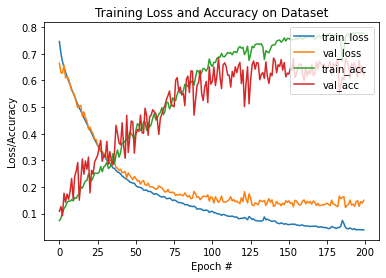

In [20]:
N = epochs
plt.figure()
plt.plot(np.arange(0, N), output_info.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), output_info.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), output_info.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), output_info.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

## Testing the model

In [21]:
prediction = model.predict(test_image_batches)

flattened_test_mask = []
flattened_prediction = []

for idx_frame in range(len(test_mask_batches)):
    ## normalizing the prediction
    frame_decoded = np.zeros((sample_size, sample_size))
    for x_i in range(sample_size):
        for y_i in range(sample_size):
            label_idx = np.argmax(prediction[idx_frame,x_i,y_i,:])
            frame_decoded[x_i,y_i] = labels[label_idx]
    ## flattening the prediction
    if idx_frame not in [9,19,29]:
        flattened_test_mask+=np.reshape(test_mask_batches[idx_frame], (-1,1)).tolist()
        flattened_prediction+=np.reshape(frame_decoded, (-1,1)).tolist()
    ## removing the duplicated area
    else:
        flattened_test_mask+=np.reshape(test_mask_batches[idx_frame][40:,:], (-1,1)).tolist()
        flattened_prediction+=np.reshape(frame_decoded[40:,:], (-1,1)).tolist()

acc_report = accuracy_report(flattened_test_mask, flattened_prediction)

unet_acc_report_df = pd.DataFrame(data=[round(acc,2) for acc in acc_report.values()], 
                             index=acc_report.keys(), 
                             columns=["U-Net accuracy (%)"])
unet_acc_report_df

,U-Net accuracy (%)
class 0,35.08
class 1,35.20
class 2,6.88
class 3,90.79
class 4,58.59
class 5,94.98
class 6,77.45
class 7,67.03
class 8,87.58
class 9,21.44


## Image mapping

In [22]:
all_image_patches, _ = crop_image(image, mask, np.arange(0,8))
all_image_patches = [im/255.0 for im in all_image_patches]

pred_image_oh = np.zeros((x_size, y_size, 14))
i = 0
for h_idx in horizontal_pixel_crop:
    for v_idx in vertical_pixel_crop:
        u_net_pred = model.predict(np.expand_dims(all_image_patches[i], axis=0))
        u_net_pred = np.squeeze(u_net_pred, axis=0)
        pred_image_oh[v_idx:v_idx+sample_size, h_idx:h_idx+sample_size, :] =u_net_pred
        i+=1

In [23]:
unet_pred_image = np.zeros((x_size, y_size), dtype=np.uint8)
for x_i in range(x_size):
    for y_i in range(y_size):
        label_idx = np.argmax(pred_image_oh[x_i,y_i,:])
        unet_pred_image[x_i,y_i] = labels[label_idx]


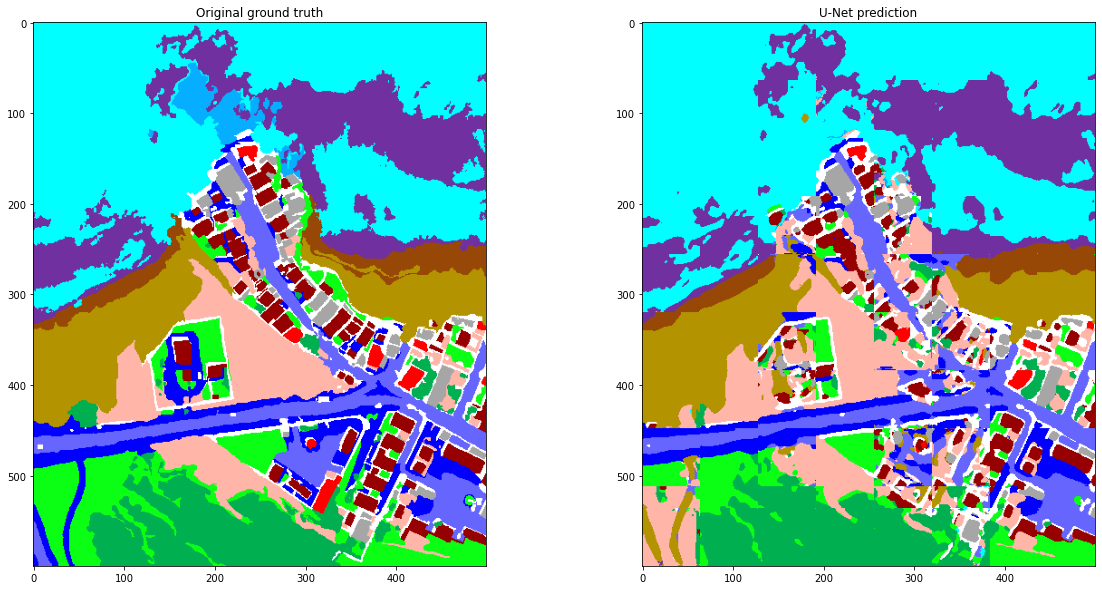

In [24]:
unet_pred_labels_map = np.reshape(unet_pred_image, mask.shape)
unet_map_rgb = labels2RGB(unet_pred_labels_map)
gt_rgb = labels2RGB(mask)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(gt_rgb)
ax1.set_title("Original ground truth")
ax2.imshow(unet_map_rgb)
ax2.set_title("U-Net prediction")
plt.show()

# SVM classification

## Preparing the data

#### Training data

In [25]:
X_tr = []
y_tr = []
train_crop_pixels = [horizontal_pixel_crop[train_idx] for train_idx in train_strip]
for train_patch_i in train_crop_pixels:
    if train_patch_i == 7:
        pixels_per_area = image[:,train_patch_i:,:]
        flattened_pixels = np.reshape(pixels_per_area, (pixels_per_area.shape[0]*pixels_per_area.shape[1],
                                                       pixels_per_area.shape[2]))
        labels_per_area = mask[:,train_patch_i:]
        flattened_labels = np.reshape(labels_per_area, (labels_per_area.shape[0]*labels_per_area.shape[1],1))
        X_tr.append(flattened_pixels)
        y_tr.append(flattened_labels)
    else:
        pixels_per_area = image[:,train_patch_i:train_patch_i+sample_size,:]
        flattened_pixels = np.reshape(pixels_per_area, (pixels_per_area.shape[0]*pixels_per_area.shape[1],
                                                       pixels_per_area.shape[2]))
        labels_per_area = mask[:,train_patch_i:train_patch_i+sample_size]
        flattened_labels = np.reshape(labels_per_area, (labels_per_area.shape[0]*labels_per_area.shape[1],1))
        X_tr.append(flattened_pixels)
        y_tr.append(flattened_labels)

X_tr = np.concatenate(X_tr[:], axis=0)
y_tr = np.concatenate(y_tr[:], axis=0)

X_tr=X_tr/255.0
y_tr = y_tr.ravel()

#### Test data

In [26]:
X_ts = []
y_ts = []
test_crop_pixels = [horizontal_pixel_crop[test_idx] for test_idx in test_strip]
for test_patch_i in test_crop_pixels:
    if test_patch_i == 7:
        pixels_per_area = image[:,test_patch_i:,:]
        flattened_pixels = np.reshape(pixels_per_area, (pixels_per_area.shape[0]*pixels_per_area.shape[1],
                                                       pixels_per_area.shape[2]))
        labels_per_area = mask[:,test_patch_i:]
        flattened_labels = np.reshape(labels_per_area, (labels_per_area.shape[0]*labels_per_area.shape[1],1))
        X_ts.append(flattened_pixels)
        y_ts.append(flattened_labels)
    else:
        pixels_per_area = image[:,test_patch_i:test_patch_i+sample_size,:]
        flattened_pixels = np.reshape(pixels_per_area, (pixels_per_area.shape[0]*pixels_per_area.shape[1],
                                                       pixels_per_area.shape[2]))
        labels_per_area = mask[:,test_patch_i:test_patch_i+sample_size]
        flattened_labels = np.reshape(labels_per_area, (labels_per_area.shape[0]*labels_per_area.shape[1],1))
        X_ts.append(flattened_pixels)
        y_ts.append(flattened_labels)

X_ts = np.concatenate(X_ts[:], axis=0)
y_ts = np.concatenate(y_ts[:], axis=0)

X_ts=X_ts/255.0
y_ts = y_ts.ravel()

## Traing and evaluating the SVM model

In [27]:
svm_model = SVC(kernel='rbf', C=200, gamma=2)
svm_model.fit(X_tr,y_tr)
y_pred = svm_model.predict(X_ts)

acc_report = accuracy_report(y_ts, y_pred)
svm_acc_report_df = pd.DataFrame(data=acc_report.values(), columns=["SVM"], index=acc_report.keys())
svm_acc_report_df

,SVM
class 0,10.644959
class 1,0.000000
class 2,67.862481
class 3,83.572782
class 4,19.013524
class 5,88.415366
class 6,71.432096
class 7,70.945946
class 8,86.727204
class 9,52.992609


## Image mapping

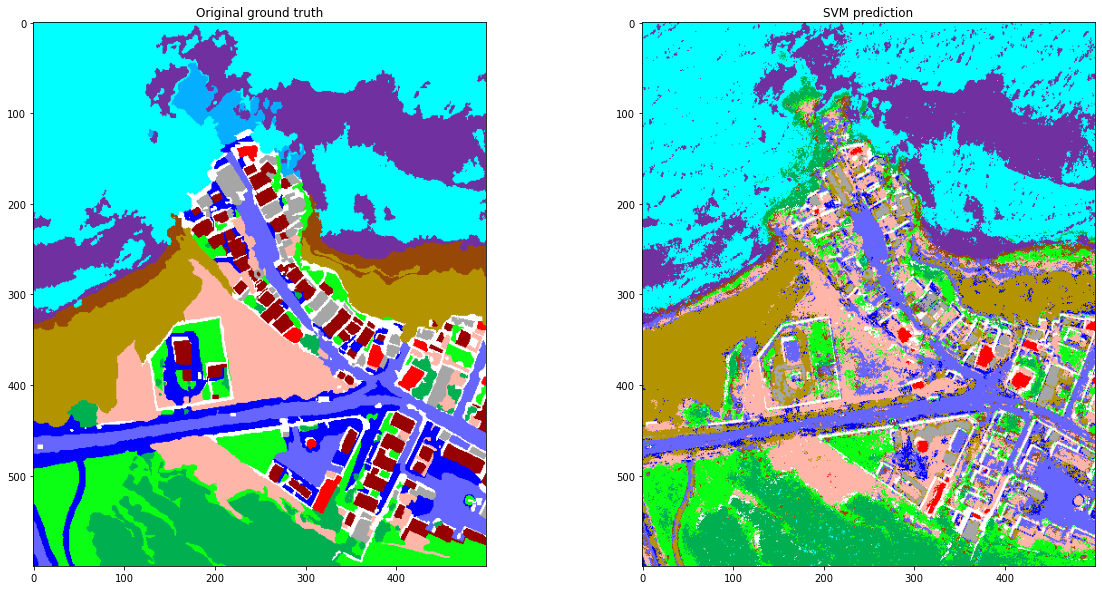

In [29]:
X_ts_map = np.reshape(image/255.0, (image.shape[0]*image.shape[1], image.shape[2]))
y_svm_pred_map = svm_model.predict(X_ts_map)

svm_pred_map = np.reshape(y_svm_pred_map, mask.shape)
svm_map_rgb = labels2RGB(svm_pred_map)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(gt_rgb)
ax1.set_title("Original ground truth")
ax2.imshow(svm_map_rgb)
ax2.set_title("SVM prediction")
plt.show()

# Performance comparison

## Numerical comparison

In [30]:
pd.concat([unet_acc_report_df,svm_acc_report_df], axis=1)

,U-Net accuracy (%),SVM
class 0,35.08,10.644959
class 1,35.20,0.000000
class 2,6.88,67.862481
class 3,90.79,83.572782
class 4,58.59,19.013524
class 5,94.98,88.415366
class 6,77.45,71.432096
class 7,67.03,70.945946
class 8,87.58,86.727204
class 9,21.44,52.992609


## Visual comparison

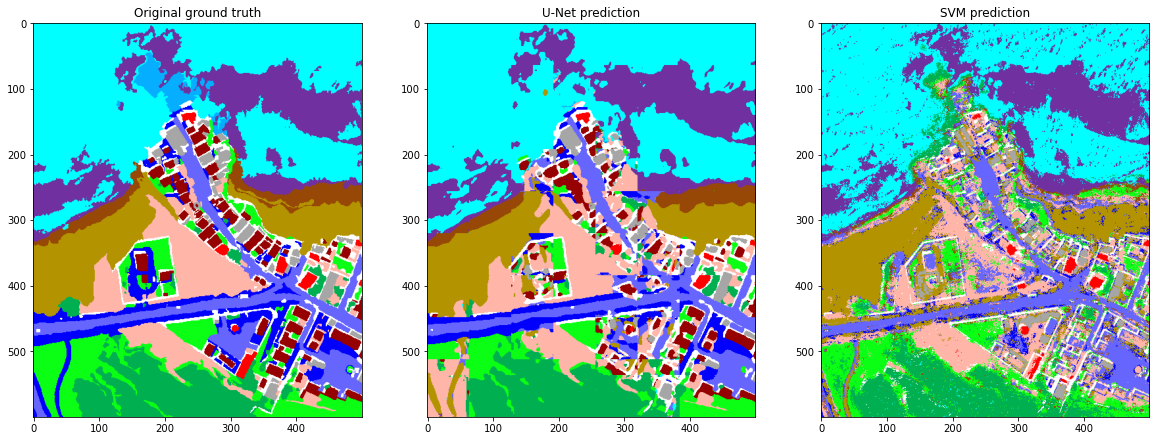

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(gt_rgb)
ax1.set_title("Original ground truth")
ax2.imshow(unet_map_rgb)
ax2.set_title("U-Net prediction")
ax3.imshow(svm_map_rgb)
ax3.set_title("SVM prediction")
plt.show()